#**Malaria Project : Infected blood cell classifier**

## Adil Bousfiha - CentraleSupelec


https://medium.com/@adilbousfiha

https://github.com/Adilbous


### In this Notebook, we will implement a Convolutional Neural Network (CNN) using Keras to classify malaria infected blood cells. It is a supervised classification problem, with two classes : uninfected and parasitized. 

### The Dataset is an Open Dataset, that you can find on Kaggle : https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria



We import some useful libraries, not exactly all of them are used in the following but I like to keep them at hand.

In [0]:
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from skimage.transform import resize
import operator
import os
from tqdm import tqdm
import itertools


from keras.models import Sequential
from keras.layers import Activation, Flatten, Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate, SpatialDropout1D, TimeDistributed, Bidirectional, LSTM, Reshape, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling2D

from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

###As I use Google Colaboratory cloud (which is free to use), this step is necessary to mount the notebook into my drive, where the dataset is. 


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
os.chdir("drive/My Drive/Malaria_project")

###Let's have a look at our blood cells, an uninfected one and a parasitized one

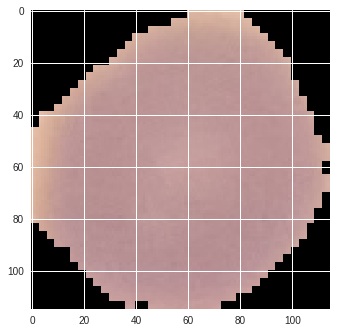

In [0]:
img = np.asarray(Image.open('Uninfected/C1_thinF_IMG_20150604_104722_cell_9.png'))
imshow(img)

###When I look at this parasitized blood cell, I immediatly think that a Convolutional Neural Network (CNN) would work pretty well for this project. Indeed, CNNs are good when it comes to detect patterns in a tensor (an image is a 3D-Tensor). 

### The parasite is localized and the color gradiant gives us a good feature that our CNN can find and learn.

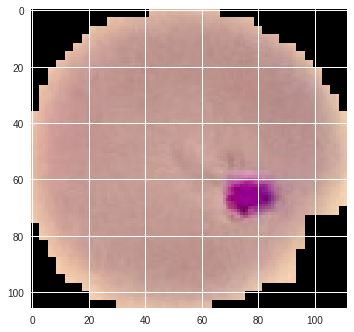

In [0]:
img2 = np.asarray(Image.open('Parasitized/C33P1thinF_IMG_20150619_115740a_cell_162.png'))
imshow(img2)

### We define a utils function that import the images, resize them and fill an array that will be our Input array. Here, I choose to resize all the images of the dataset (they have different sizes) to (24, 24, 3) arrays.

In [0]:
def import_resize(directory, file_name, x1, x2):
  imgList = os.listdir(directory)
  n = len(imgList)
  imgX = np.zeros((n, x1, x2, 3))

  for i in tqdm(range (0,n)):
    img = np.asarray(Image.open(directory + imgList[i]))
    img_resize = resize(img, [x1, x2,3])
    X = np.reshape(img_resize, [ 1, x1, x2,3])
    imgX[i] = X

  np.savez(file_name, imgX)

In [0]:
import_resize('Uninfected/', 'uninfected_imgX', 24, 24)

In [0]:
import_resize('Parasitized/', 'parasitized_imgX', 24, 24)

In [0]:
u_imgX = np.load("uninfected_imgX.npz")['arr_0']
p_imgX = np.load("parasitized_imgX.npz")['arr_0']

### Here, we created to y arrays, that will be our labels. As we imported the uninfected cells and the paratized cells in two different arrays, we also have to merge them and shuffle them.

In [0]:
n = len(u_imgX) 
n_p = len(p_imgX)

u_y = np.zeros(n)
p_y = np.ones(n_p)

In [0]:
X = np.vstack((u_imgX, p_imgX))
y = np.hstack((u_y,p_y))

X, y = shuffle(X, y, random_state=0)

In [0]:
y_ohe = np_utils.to_categorical(y, 2)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.20)

###We will use a two-convolutional layers CNN, connected to two dense layers, one of which is the output layer. As we have 2 classes, this output layers will have 2 neurons.

In [0]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu' , input_shape = (24, 24, 3)))
model.add(MaxPooling2D( pool_size = (2,2) ))

model.add(Conv2D(32, (3, 3), activation='relu' , input_shape = (24, 24, 3)))
model.add(MaxPooling2D( pool_size = (2,2) ))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 22, 22, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 32)          4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

In [0]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 32
EPOCHS = 15

callbacks_list = [
    ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='acc', patience=5)
]

history = model.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

model.save('CNN_malaria_classifier.h5')  # creates a HDF5 file 'my_model.h5'

Train on 17712 samples, validate on 4428 samples
Epoch 1/15
17712/17712 [==============================] - 12s 700us/step - loss: 0.5881 - acc: 0.6899 - val_loss: 0.4634 - val_acc: 0.7839
Epoch 2/15
17712/17712 [==============================] - 12s 679us/step - loss: 0.3718 - acc: 0.8333 - val_loss: 0.2717 - val_acc: 0.8968
Epoch 3/15
17712/17712 [==============================] - 12s 682us/step - loss: 0.2360 - acc: 0.9062 - val_loss: 0.2147 - val_acc: 0.9178
Epoch 4/15
17712/17712 [==============================] - 12s 673us/step - loss: 0.1916 - acc: 0.9278 - val_loss: 0.2000 - val_acc: 0.9280
Epoch 5/15
17712/17712 [==============================] - 12s 669us/step - loss: 0.1677 - acc: 0.9385 - val_loss: 0.1899 - val_acc: 0.9248
Epoch 6/15
17712/17712 [==============================] - 12s 662us/step - loss: 0.1540 - acc: 0.9462 - val_loss: 0.1750 - val_acc: 0.9399
Epoch 7/15
17712/17712 [==============================] - 12s 664us/step - loss: 0.1423 - acc: 0.9502 - val_loss: 0.1

In [0]:
y_pred = model.predict(X_test)

In [0]:
y_pred_scalar = [max(enumerate(score), key=operator.itemgetter(1))[0] for score in y_pred]
y_test_scalar = [max(enumerate(score), key=operator.itemgetter(1))[0] for score in y_test]

###The accuracy score on the test set is close to 0.95, which is pretty good. Of course, the dataset is already cleaned and processed beforehand. We may expect a lower accuracy on "real, on-the-ground" data.

In [0]:
accuracy_score(y_test_scalar, y_pred_scalar, normalize=True, sample_weight=None)

0.9483381502890174

##Model accuracy

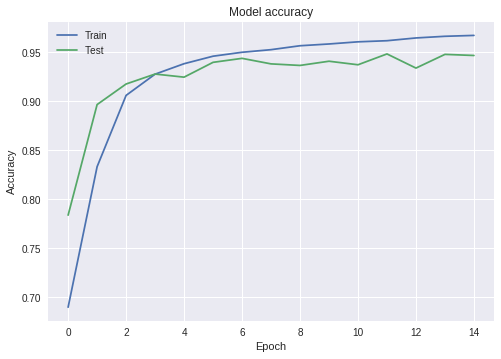

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##Model loss

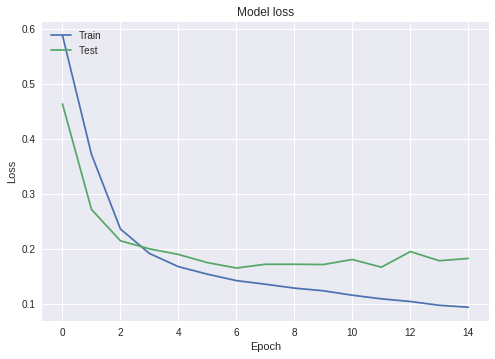

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

##Confusion Matrix

Confusion matrix, without normalization
[[2653  117]
 [ 169 2597]]
Normalized confusion matrix
[[0.96 0.04]
 [0.06 0.94]]


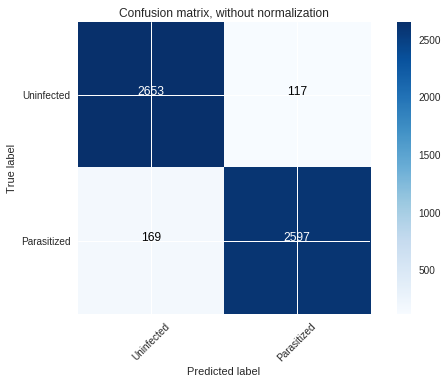

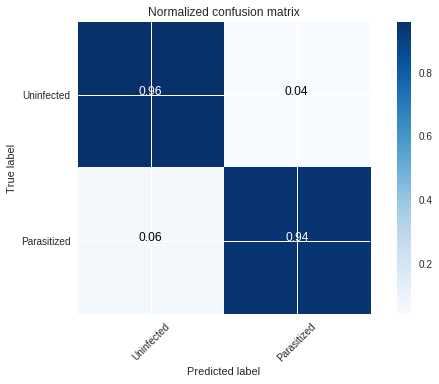

In [0]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_scalar, y_pred_scalar)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['Uninfected', 'Parasitized']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### This is a small utils function that identify the images for which our model was wrong. It will allow us to have a look at the kind of images our model gets wrong, thus helping us improve it.

In [0]:
for i in range (0,len(y_pred_scalar)):
  if y_pred_scalar[i] != y_test_scalar[i] : 
    print( i, ' has been classified as ', y_pred_scalar[i], " and should b ", y_test_scalar[i])

##Classified as parasitized, should be uninfected

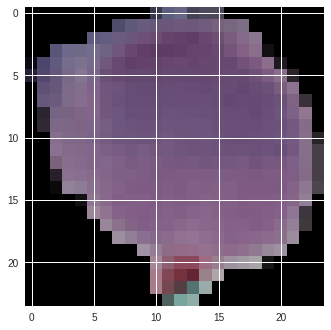

In [0]:
imshow(X_test[33])

##Classified as uninfected, should be parasitized

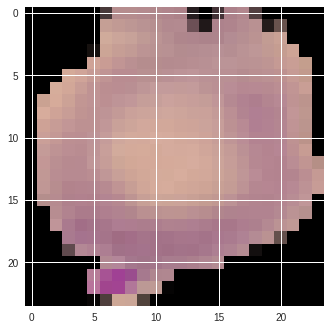

In [0]:
imshow(X_test[1682])